In [84]:
import pandas as pd
import numpy as np

df = pd.read_csv('tcs.csv', index_col='Date', parse_dates=True)
df

,Open,High,Low,Close,SMA_20,EMA_20,RSI,MACD,MACD_signal
Date,,,,,,,,,
2014-04-01,871.111120,887.355616,871.070469,883.984863,873.551822,870.672133,53.498830,-6.304241,-7.382951
2014-04-02,889.386045,894.259394,877.629113,882.177551,872.162906,871.767887,52.861115,-4.614631,-6.829287
2014-04-03,882.421015,886.136903,872.166681,879.842163,870.428799,872.536866,51.998565,-3.424572,-6.148344
2014-04-04,882.076173,888.167860,865.019452,868.613586,868.359644,872.163220,47.947542,-3.348890,-5.588453
2014-04-07,865.060092,879.619163,861.242576,874.684937,866.842807,872.403384,50.206416,-2.767107,-5.024184
...,...,...,...,...,...,...,...,...,...
2024-04-15,4001.399902,4064.199951,3919.050049,3941.199951,3979.142493,3979.181907,45.685082,-18.998358,-22.386624
2024-04-16,3902.000000,3928.699951,3862.850098,3872.800049,3962.402490,3969.050301,40.380290,-25.069488,-22.923197
2024-04-18,3876.800049,3936.000000,3850.000000,3862.000000,3944.539990,3958.855035,39.598434,-30.401922,-24.418942


In [85]:
dataset_train = df.iloc[:int(0.8*len(df))]
dataset_test = df.iloc[int(0.8*len(df)):]

len(dataset_train), len(dataset_test)

(1981, 496)

In [86]:
x_train = []
y_train = []
for i in range(1, len(dataset_train)):
    x_train.append(dataset_train.iloc[i-1])  # Select all columns for row i-1
    y_train.append(dataset_train.iloc[i, 3])  # Select only column at index 3

x_train, y_train = np.array(x_train), np.array(y_train)

In [87]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

LinearModel = LinearRegression()
LinearModel.fit(x_train,y_train)


xgbmodel = XGBRegressor()
xgbmodel.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [104]:
x_test = []
y_test = []
for i in range(1, len(dataset_test)):
    x_test.append(dataset_test.iloc[i-1])
    y_test.append(dataset_test.iloc[i, 3])

x_test, y_test = np.array(x_test), np.array(y_test)

y_pred = LinearModel.predict(x_test)
y_pred_xgb = xgbmodel.predict(x_test)

In [88]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
lstm_data = df.values
lstm_data = scaler.fit_transform(lstm_data)

lstm_train = lstm_data[:int(0.8*len(lstm_data))]
lstm_test = lstm_data[int(0.8*len(lstm_data)):]

x_lstm_train = []
y_lstm_train = []

for i in range(60, len(lstm_train)):
    x_lstm_train.append(lstm_train[i-60:i]) # Select all columns for rows i-60 to i-1
    y_lstm_train.append(lstm_train[i, 3]) # Select only column at index 3 for row i

x_lstm_train, y_lstm_train = np.array(x_lstm_train), np.array(y_lstm_train)

x_lstm_train.shape, y_lstm_train.shape

((1921, 60, 9), (1921,))

In [89]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

lstm = Sequential()

lstm.add(LSTM(units=50, return_sequences=True, input_shape=(x_lstm_train.shape[1], x_lstm_train.shape[2]))) # 50 neurons, return_sequences=True for stacked LSTM
lstm.add(Dropout(0.2)) # Dropout layer to prevent overfitting

lstm.add(LSTM(units=50, return_sequences=True)) 
lstm.add(Dropout(0.2))

lstm.add(LSTM(units=50, return_sequences=True)) 
lstm.add(Dropout(0.2))

lstm.add(LSTM(units=50))
lstm.add(Dropout(0.2))

lstm.add(Dense(units=1))

lstm.compile(optimizer='adam', loss='mean_squared_error')

lstm.fit(x_lstm_train, y_lstm_train, epochs=100, batch_size=32)

Epoch 1/100
61/61 [==============================] - 8s 48ms/step - loss: 0.0102
Epoch 2/100
61/61 [==============================] - 3s 49ms/step - loss: 0.0028
Epoch 3/100
61/61 [==============================] - 3s 49ms/step - loss: 0.0035
Epoch 4/100
61/61 [==============================] - 3s 46ms/step - loss: 0.0020
Epoch 5/100
61/61 [==============================] - 3s 45ms/step - loss: 0.0015
Epoch 6/100
61/61 [==============================] - 3s 45ms/step - loss: 0.0019
Epoch 7/100
61/61 [==============================] - 3s 46ms/step - loss: 0.0022
Epoch 8/100
61/61 [==============================] - 3s 49ms/step - loss: 0.0026
Epoch 9/100
61/61 [==============================] - 3s 46ms/step - loss: 0.0017
Epoch 10/100
61/61 [==============================] - 3s 46ms/step - loss: 0.0014
Epoch 11/100
61/61 [==============================] - 3s 47ms/step - loss: 0.0017
Epoch 12/100
61/61 [==============================] - 3s 46ms/step - loss: 0.0014
Epoch 13/100
61/61 [=====

In [105]:
input = lstm_test
print(input[-1])
x_test_lstm = []
for i in range(60, len(input)):
    x_test_lstm.append(input[i-60:i,:])

x_test_lstm = np.array(x_test_lstm)
y_pred_lstm = lstm.predict(x_test_lstm)

zero_arr = np.zeros((y_pred_lstm.shape[0], 9))
zero_arr[:,3] = y_pred_lstm[:,0]

y_pred_lstm = scaler.inverse_transform(zero_arr)
y_pred_lstm = y_pred_lstm[:,3]

[0.88847624 0.88939876 0.89152975 0.89544892 0.94533795 0.94727693
 0.3061035  0.31060433 0.30542068]
14/14 [==============================] - 0s 18ms/step


In [106]:
y_test[-1], y_pred[-1], y_pred_xgb[-1], y_pred_lstm[-1]

(3864.60009765625, 3834.0454841222645, 3478.0059, 3653.830969701849)

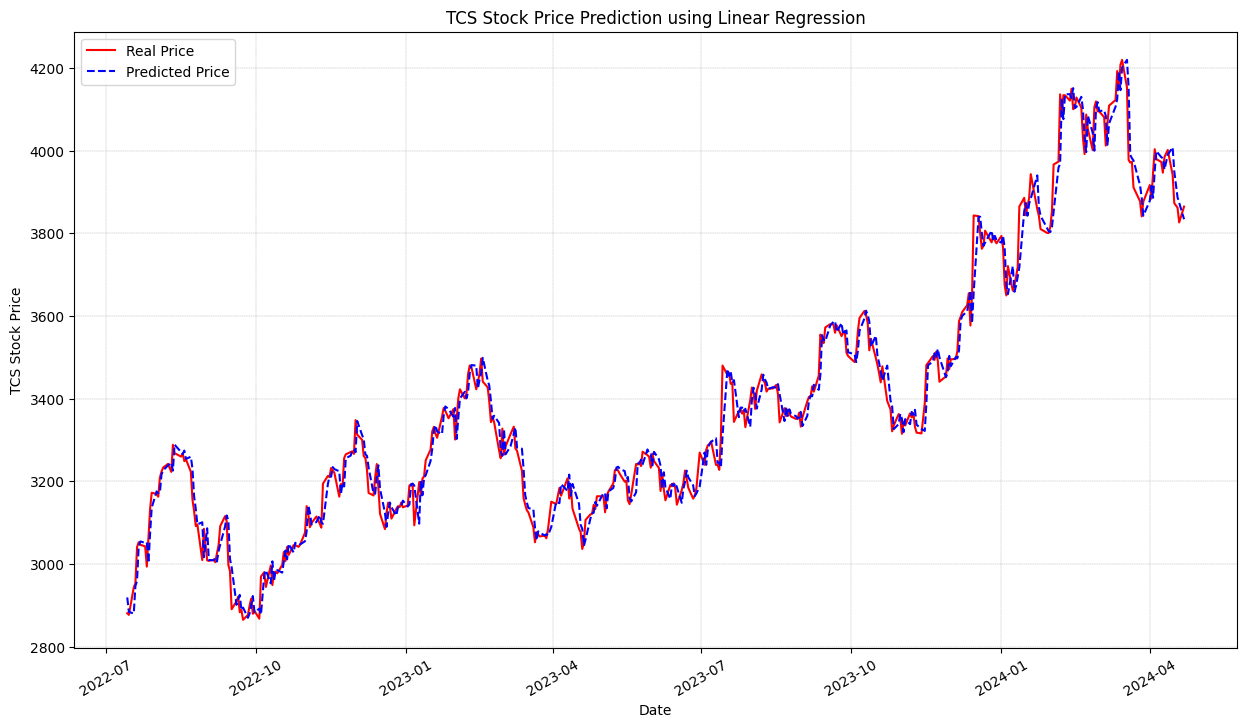

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))  
plt.plot(dataset_test.index[61:], y_test[60:], color='red', label='Real Price')
plt.plot(dataset_test.index[61:], y_pred[60:], color='blue',linestyle='--', label='Predicted Price')
plt.grid(True, linestyle='--', linewidth=0.3, color='gray', which='both', alpha=0.7)
plt.title('TCS Stock Price Prediction using Linear Regression')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('TCS Stock Price')
plt.legend()
plt.show()


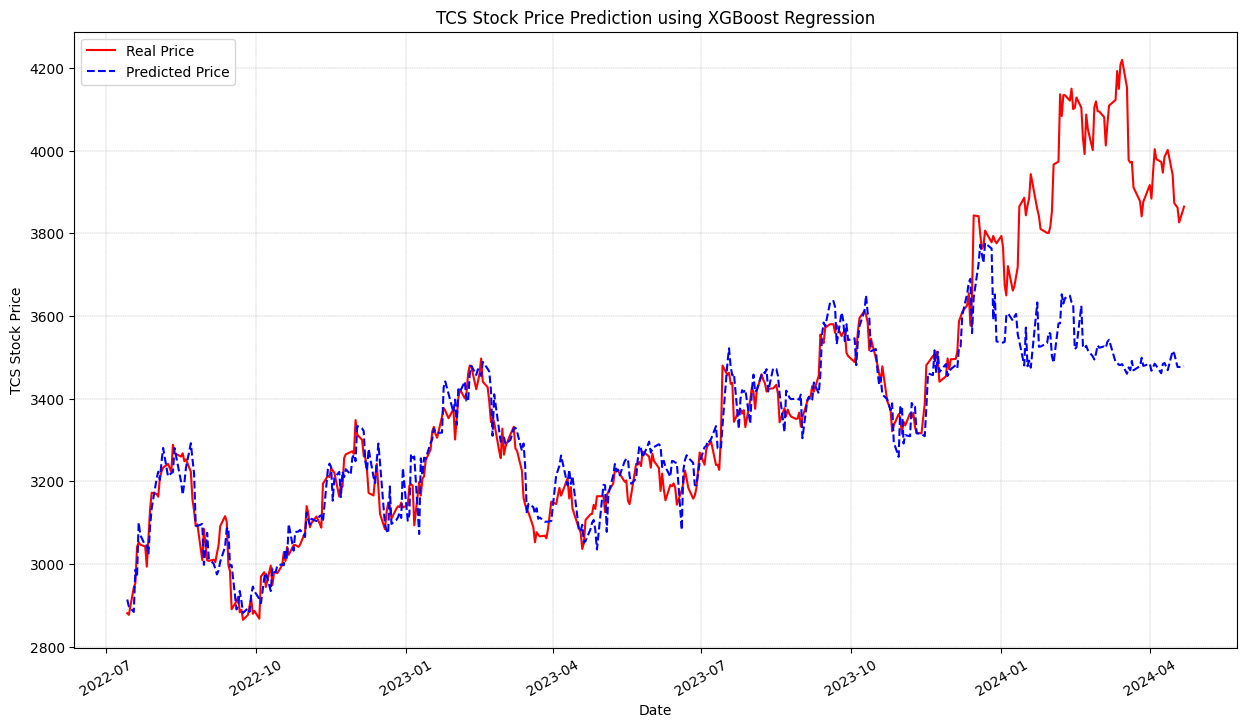

In [108]:
plt.figure(figsize=(15, 8))  
plt.plot(dataset_test.index[61:], y_test[60:], color='red', label='Real Price')
plt.plot(dataset_test.index[61:], y_pred_xgb[60:], color='blue',linestyle='--', label='Predicted Price')
plt.grid(True, linestyle='--', linewidth=0.3, color='gray', which='both', alpha=0.7)
plt.title('TCS Stock Price Prediction using XGBoost Regression')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('TCS Stock Price')
plt.legend()
plt.show()


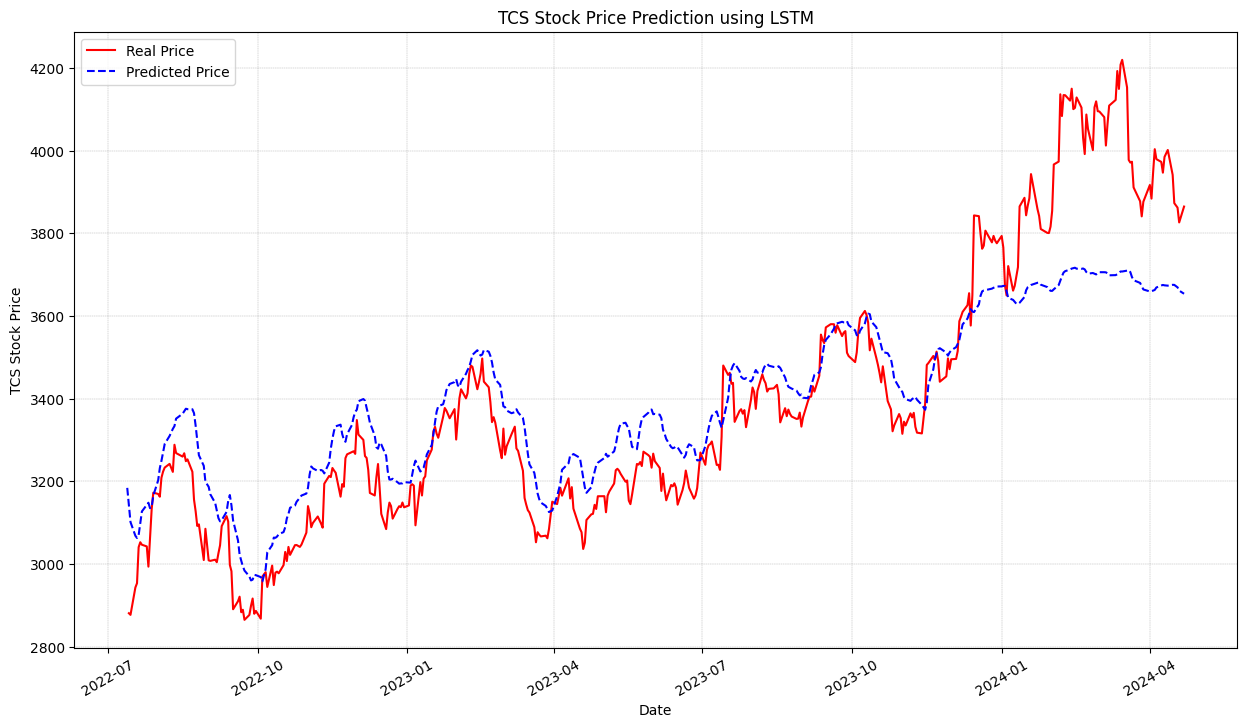

In [115]:
plt.figure(figsize=(15, 8))  
plt.plot(dataset_test.index[61:], y_test[60:], color='red', label='Real Price')
plt.plot(dataset_test.index[60:], y_pred_lstm, color='blue',linestyle='--', label='Predicted Price')
plt.grid(True, linestyle='--', linewidth=0.3, color='gray', which='both', alpha=0.7)
plt.title('TCS Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('TCS Stock Price')
plt.legend()
plt.show()

In [116]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def mean_directional_accuracy(true_values, predicted_values):
    # Calculate the directional accuracy
    directional_accuracy = np.sign(np.diff(true_values)) == np.sign(np.diff(predicted_values))
    # Calculate the mean directional accuracy
    mda = np.mean(directional_accuracy)
    return mda

r2_linear = r2_score(y_test[60:], y_pred[60:])
r2_xgb = r2_score(y_test[60:], y_pred_xgb[60:])
r2_lstm = r2_score(y_test[60:], y_pred_lstm[1:])

rmse_linear = mean_squared_error(y_test[60:], y_pred[60:], squared=False)
rmse_xgb = mean_squared_error(y_test[60:], y_pred_xgb[60:], squared=False)
rmse_lstm = mean_squared_error(y_test[60:], y_pred_lstm[1:], squared=False)

mae_linear = mean_absolute_error(y_test[60:], y_pred[60:])
mae_xgb = mean_absolute_error(y_test[60:], y_pred_xgb[60:])
mae_lstm = mean_absolute_error(y_test[60:], y_pred_lstm[1:])

mda_linear = mean_directional_accuracy(y_test[60:], y_pred[60:])
mda_xgb = mean_directional_accuracy(y_test[60:], y_pred_xgb[60:])
mda_lstm = mean_directional_accuracy(y_test[60:], y_pred_lstm[1:])


In [126]:
# Define models, metrics, and scores
models = ['Linear Regression', 'XGBoost', 'LSTM']
metrics = ['R-squared (R²)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'Mean Directional Accuracy (MDA)']
scores = [
    [r2_linear, r2_xgb, r2_lstm],
    [rmse_linear, rmse_xgb, rmse_lstm],
    [mae_linear, mae_xgb, mae_lstm],
    [mda_linear, mda_xgb, mda_lstm]
]

# Round scores to two decimal places
rounded_scores = np.round(scores, 2)

# Create DataFrame
df = pd.DataFrame(rounded_scores, columns=models, index=metrics)

print(df)

df.to_csv('scores.csv')

                                 Linear Regression  XGBoost    LSTM
R-squared (R²)                                0.98     0.63    0.77
Root Mean Squared Error (RMSE)               41.59   195.72  152.03
Mean Absolute Error (MAE)                    30.64   108.72  114.36
Mean Directional Accuracy (MDA)               0.49     0.47    0.48


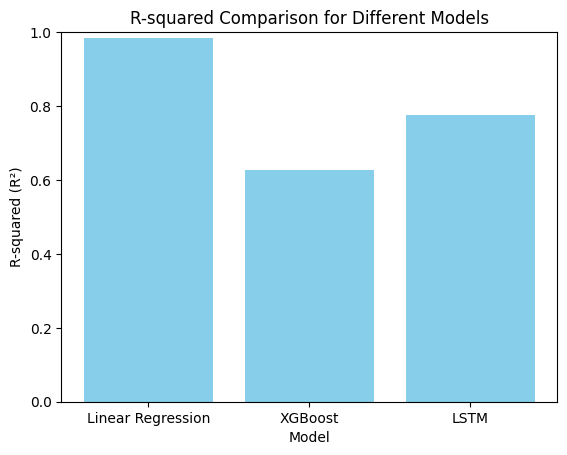

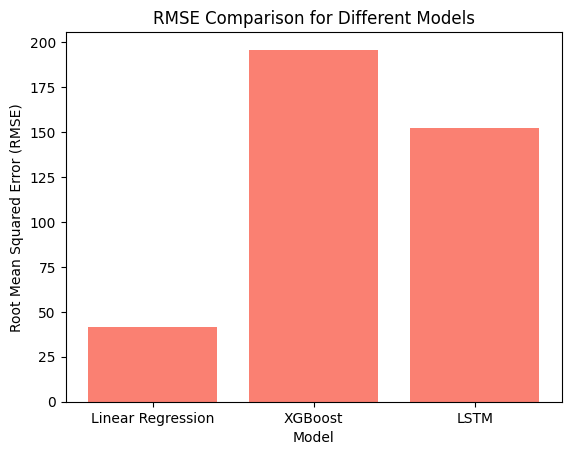

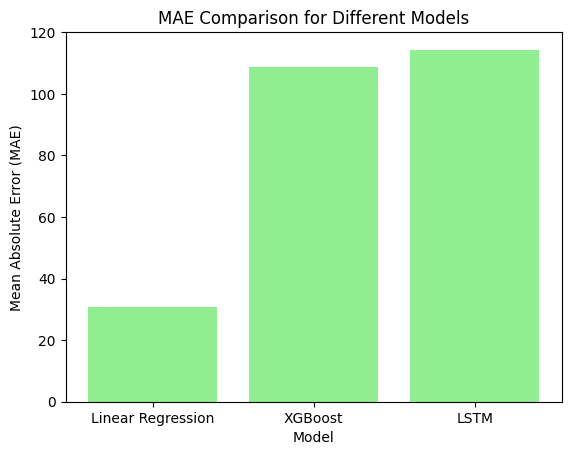

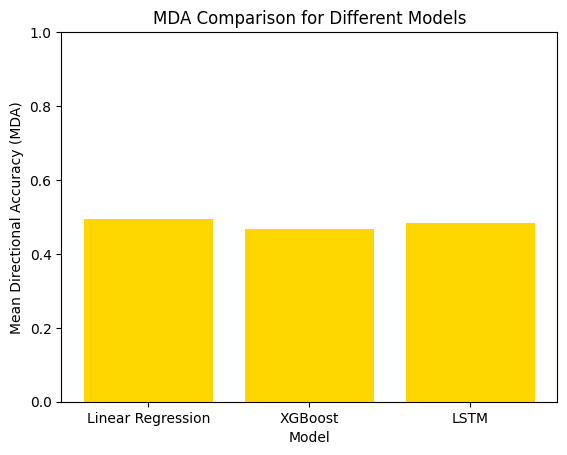

In [119]:
# Define the evaluation metrics for each model
models = ['Linear Regression', 'XGBoost', 'LSTM']
r2_scores = [r2_linear, r2_xgb, r2_lstm]
rmse_scores = [rmse_linear, rmse_xgb, rmse_lstm]
mae_scores = [mae_linear, mae_xgb, mae_lstm]
mda_scores = [mda_linear, mda_xgb, mda_lstm]

# Plotting R-squared
plt.bar(models, r2_scores, color='skyblue')
plt.xlabel('Model')
plt.ylabel('R-squared (R²)')
plt.title('R-squared Comparison for Different Models')
plt.ylim(0, 1)  # Setting y-axis limit from 0 to 1 for R-squared
plt.show()

# Plotting RMSE
plt.bar(models, rmse_scores, color='salmon')
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE Comparison for Different Models')
plt.show()

# Plotting MAE
plt.bar(models, mae_scores, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE Comparison for Different Models')
plt.show()

# Plotting MDA
plt.bar(models, mda_scores, color='gold')
plt.xlabel('Model')
plt.ylabel('Mean Directional Accuracy (MDA)')
plt.title('MDA Comparison for Different Models')
plt.ylim(0, 1)  # Setting y-axis limit from 0 to 1 for MDA
plt.show()
